# Hindi2vec Language Model Pre-training

The goal of this notebook is to train a language model using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182), with data from [Hindi Wikipedia Dump](https://dumps.wikimedia.org/hiwiki/latest/hiwiki-latest-pages-articles.xml.bz2). 

## EDIT THIS 
# TK
Using 40M/200k/200k tokens of train-validation-test split, we achieved validation perplexity of **27.81627 with 60,004 embeddings at 400 dimensions**, compared to state-of-the-art as of October 27, 2018 at **42.41 for English WikiText-2 by [Yang et al (2018)](https://arxiv.org/abs/1711.03953)**. To the best of our knowledge, there is no comparable research in Thai language at the point of writing (February 17, 2019).

Our workflow is as follows:

* Retrieve and process [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) according to [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual)
* Perform 40M/200k/200k tokens of train-validation-test split split
* Minimal text cleaning and tokenization using `newmm` with frozen dictionary (`engine='ulmfit'`) of [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)
* Train language model
* Evaluate model based on perplexity and eyeballing
* Extract embeddings to use as "word2vec"

## Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger

lang = "hi"

## Text Cleaning

In [ ]:
# Download the Wikipedia dump, 
# Uncomment when running for the first time
# url = f"https://dumps.wikimedia.org/{lang}wiki/latest/{lang}wiki-latest-pages-articles.xml.bz2"
# !wget -c $url

In [ ]:
# Extract the bz2 file
filename = f"{lang}wiki-latest-pages-articles.xml"
compressed_filename = filename+".bz2"
# Uncomment when running for the first time
# !bzip2 -dk $compressed_filename

In [ ]:
# Uncomment when running for the first time
# !git clone https://github.com/n-waves/ulmfit-multilingual

We follow the dataset creation, pre- and post-processing of [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual):

* `ulmfit/create_wikitext.py` - Download thwiki in json format and separate them into 40M/200k/200k tokens of train-validation-test split. Articles with least than 100 tokens are removed. Also perform tokenization with whitespaces as separators.
* `ulmfit/postprocess_wikitext.py` - Replace numbers and replace out-of-vocabulary tokens with `xxunk` (frequency of less than 3).

We replaced the Moses Tokenizer with the following code to use [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)'s `newmm` dictionary-based tokenizer with a frozen dictionary instead. We join the tokens within an article together to be tokenized later by the data bunch.

In [ ]:
# Uncomment when running for the first time
# !git clone https://github.com/attardi/wikiextractor/

In [ ]:
!cat wikiextractor/README.md

In [41]:
# Uncomment when running for the first time, this can take a few minutes
# This is run in quiet mode, remove --quiet if you want to see progress status

# !python wikiextractor/WikiExtractor.py $filename -o data/wiki_extr --json --quiet

wikiextractor/WikiExtractor.py:2432: DeprecationWarning: Flags not at the start of the expression '\\[(((?i)bitcoin:|ftp' (truncated)
  re.S | re.U)
wikiextractor/WikiExtractor.py:2439: DeprecationWarning: Flags not at the start of the expression '^(http://|https://)(' (truncated)
  re.X | re.S | re.U)
wikiextractor/WikiExtractor.py:645: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  self.title, self.id, *errs)
wikiextractor/WikiExtractor.py:645: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  self.title, self.id, *errs)
wikiextractor/WikiExtractor.py:645: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  self.title, self.id, *errs)


In [42]:
!ls data/wiki_extr/*

data/wiki_extr/AA:
wiki_00  wiki_12  wiki_24  wiki_36  wiki_48  wiki_60  wiki_72  wiki_84	wiki_96
wiki_01  wiki_13  wiki_25  wiki_37  wiki_49  wiki_61  wiki_73  wiki_85	wiki_97
wiki_02  wiki_14  wiki_26  wiki_38  wiki_50  wiki_62  wiki_74  wiki_86	wiki_98
wiki_03  wiki_15  wiki_27  wiki_39  wiki_51  wiki_63  wiki_75  wiki_87	wiki_99
wiki_04  wiki_16  wiki_28  wiki_40  wiki_52  wiki_64  wiki_76  wiki_88
wiki_05  wiki_17  wiki_29  wiki_41  wiki_53  wiki_65  wiki_77  wiki_89
wiki_06  wiki_18  wiki_30  wiki_42  wiki_54  wiki_66  wiki_78  wiki_90
wiki_07  wiki_19  wiki_31  wiki_43  wiki_55  wiki_67  wiki_79  wiki_91
wiki_08  wiki_20  wiki_32  wiki_44  wiki_56  wiki_68  wiki_80  wiki_92
wiki_09  wiki_21  wiki_33  wiki_45  wiki_57  wiki_69  wiki_81  wiki_93
wiki_10  wiki_22  wiki_34  wiki_46  wiki_58  wiki_70  wiki_82  wiki_94
wiki_11  wiki_23  wiki_35  wiki_47  wiki_59  wiki_71  wiki_83  wiki_95

data/wiki_extr/AB:
wiki_00  wiki_12  wiki_24  wiki_36  wiki_48  wiki_60  wiki_72  wiki_84	wiki_9

In [43]:
!python ulmfit-multilingual/ulmfit/create_wikitext.py -i data/wiki_extr/ -o data/wiki/ -l hi

Writing to data/wiki/hi-2/hi.wiki.train.tokens...
Processed 10,000 documents. Total # tokens: 1,912,375.
data/wiki/hi-2/hi.wiki.train.tokens. # documents: 11,947. # tokens: 2,000,063.
Copying data/wiki/hi-2/hi.wiki.train.tokens to data/wiki/hi-100/hi.wiki.train.tokens & data/wiki/hi-all/hi.wiki.train.tokens.
Writing to data/wiki/hi-2/hi.wiki.valid.tokens...
data/wiki/hi-2/hi.wiki.valid.tokens. # documents: 242. # tokens: 200,986.
Copying data/wiki/hi-2/hi.wiki.valid.tokens to data/wiki/hi-100/hi.wiki.valid.tokens & data/wiki/hi-all/hi.wiki.valid.tokens.
Writing to data/wiki/hi-2/hi.wiki.test.tokens...
data/wiki/hi-2/hi.wiki.test.tokens. # documents: 154. # tokens: 204,765.
Copying data/wiki/hi-2/hi.wiki.test.tokens to data/wiki/hi-100/hi.wiki.test.tokens & data/wiki/hi-all/hi.wiki.test.tokens.
Writing to data/wiki/hi-100/hi.wiki.train.tokens...
Processed 10,000 documents. Total # tokens: 4,134,864.
Processed 30,000 documents. Total # tokens: 11,013,897.
Processed 40,000 documents. Tota

In [44]:
!wc -l data/wiki/hi-2/hi.wiki.valid.tokens

4364 data/wiki/hi-2/hi.wiki.valid.tokens


In [45]:
data_path = f"data/wiki/{lang}-2/"
model_path = f"models/wiki/{lang}-2"
assert Path(data_path).exists()

In [50]:
def istitle(line):
    return len(re.findall(r'^ ?=\|[^=]*\|= ?$', line)) != 0

def read_wiki_articles(filename):
    articles = []
    with open(filename, encoding='utf8') as f:
        lines = f.readlines()
    current_article = []
    for i,line in enumerate(lines):
        current_article.append(line)
        if i < len(lines)-2 and lines[i+1].strip() == "" and istitle(lines[i+2]):
            articles.append("".join(current_article))
            current_article = []
        articles.append("".join(current_article))
#     print(current_article[:10])
    print(f"Wiki text was split to {len(articles)} articles")
    return pd.DataFrame({'texts': np.array(articles, dtype=np.object)})

In [ ]:
#last line is corrupted
train_df = read_wiki_articles(f'{data_path}{lang}.wiki.train.tokens').iloc[:-1,:]
valid_df = read_wiki_articles(f'{data_path}{lang}.wiki.valid.tokens').iloc[:-1,:]
test_df = read_wiki_articles(f'{data_path}{lang}.wiki.test.tokens').iloc[:-1,:]
train_df.shape, valid_df.shape, test_df.shape

In [49]:
len(train_df)

,texts


In [30]:
#join tokens together, I think this is unique to Thai tokenization
train_df['texts'] = train_df.texts.map(lambda x: ''.join(x.split('|')))
valid_df['texts'] = valid_df.texts.map(lambda x: ''.join(x.split('|')))
test_df['texts'] = test_df.texts.map(lambda x: ''.join(x.split('|')))

In [32]:
train_df['texts']

Series([], Name: texts, dtype: object)

## Data Preparation

We used the `newmm` engine of `pyThaiNLP` to perform tokenization. Out of randomnum tokens from all of training set, we chose 60,000 embeddings (plus two for unknown and padding) of tokens which appeared more than twice (not typos) in the training set.


We perform the following text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

### Thai Tokenizer

We use the `newmm` tokenizer with a dictionary frozen as of 2018-10-23.

In [33]:
text='วิทยาศาสตร์ดาวเคราะห์เป็นสาขาวิชาที่ศึกษาเกี่ยวกับองค์ประกอบของดาวเคราะห์'
a = word_tokenize(text,engine='ulmfit')
a

['วิทยาศาสตร์',
 'ดาวเคราะห์',
 'เป็น',
 'สาขาวิชา',
 'ที่',
 'ศึกษา',
 'เกี่ยวกับ',
 'องค์ประกอบ',
 'ของ',
 'ดาวเคราะห์']

In [4]:
#integrated into pythainlp.ulmfit.utils
from fastai.text.transform import *
from pythainlp.tokenize import word_tokenize
from pythainlp.util import normalize as normalize_char_order

class ThaiTokenizer(BaseTokenizer):
    "Wrapper around a newmm tokenizer to make it a `BaseTokenizer`."
    def __init__(self, lang = 'th'):
        self.lang = lang
    def tokenizer(self, t):
        return word_tokenize(t,engine='ulmfit')
    def add_special_cases(self, toks):
        pass
    
def replace_rep_after(t):
    "Replace repetitions at the character level in `t` after the repetition"
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c} {TK_REP} {len(cc)+1} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)

def rm_useless_newlines(t):
    "Remove multiple newlines in `t`."
    return re.sub('[\n]{2,}', ' ', t)

def rm_brackets(t):
    "Remove all empty brackets from `t`."
    new_line = re.sub('\(\)','',t)
    new_line = re.sub('\{\}','',new_line)
    new_line = re.sub('\[\]','',new_line)
    return(new_line)

#in case we want to add more specific rules for thai
pre_rules_th = [fix_html, replace_rep_after, normalize_char_order, 
                spec_add_spaces, rm_useless_spaces, rm_useless_newlines, rm_brackets]
post_rules_th = [replace_all_caps, deal_caps]

### Data Bunch

We trained the language model based on 40M/200k/200k tokens of train-validation-test split from [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2). Tokens are generated and numericalized filtering all words with frequency more than 3 and at maximum vocab size of 60,000 (plus unknown and padding tokens).

In [5]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

In [40]:
data = (ItemLists(model_path, 
    TextList.from_df(train_df, model_path, cols=['texts'], processor=processor),
    TextList.from_df(valid_df, model_path, cols=['texts'], processor=processor))
    .label_for_lm()
    .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
    .databunch(bs=64))
data.sanity_check()

In [ ]:
%time
data.save(f"{lang}wiki_lm_data.pkl")

In [6]:
%time
data = load_data(model_path,"{lang}wiki_lm_data.pkl")
data.sanity_check()
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(20496, 491, 476)

In [42]:
data.show_batch(5)

idx,text
0,ที่ บ้าน คุณตา คุณยาย ขณะที่ หยุดพัก ใต้ ร่มไม้ ใหญ่ ชายป่า เกิด เจ็บท้อง กะทันหัน และ ได้ คลอด บุตรชาย ออกมา จึง ได้ ตั้ง ชื่อว่า “ เด็กชาย พัก ” \n \n บรรพชา และ อุปสมบท . \n เมื่อ อายุ ๘ ขวบ โยม บิดา ได้ พา เข้า กรุง เทพ
1,"ถ่ายทำ พร้อมกับ เรื่อง ""อ เวน เจอ ร์ส: มหา สงคราม ล้าง จักรวาล "" และ ถ่ายทำ เสร็จสิ้น ใน เดือน มกราคม ค.ศ. 2018 ชื่อเรื่อง xxmaj avengers : xxmaj xxunk เปิดเผย อย่างเป็นทางการ ใน ตัวอย่าง ภาพยนตร์ ที่ เผยแพร่ ใน เดือน ธันวาคม 2018 \n \n อ เวน เจอ ร์ส:"
2,\n \n พลัง ศักติ ของ พระองค์ : ผู้ ที่ นับถือ บูชา เทวี องค์ นี้ จะ ได้รับ พร จาก พระ ส กันทะ ( หรือ ที่ เรียก ว่า กร รติ เก ยะ ) เทพ แห่ง สงคราม \n \n ประวัติ ความเป็นมา ของ พระองค์ : พระองค์ ถือกำเนิด มา เพื่อ มา ปราบ อสูร ที่ มี
3,"นิ้ว ) ใกล้ กับ แหลม xxmaj xxunk และ กองทัพเรือ ฟินแลนด์ ได้ รวม รวม กองเรือ ตอร์ปิโด มอเตอร์ ( xxmaj motor xxmaj xxunk xxmaj boat ) ที่ 2 กับ เรือ xxunk xxup xxunk 9, xxup xxunk 10, xxup xxunk 11 และ xxup"
4,แสดง ทัศนะ ด้าน การเมือง ศาสนา หรือ คำคม ส่วนตัว โดย พิมพ์ ไว้ บน เสื้อ ใน เป็นเหตุให้ คณะกรรมการ สมาคม ฟุตบอล ระหว่างประเทศ ออก กฎ ใน ปี ค.ศ. 2002 ห้าม มี การเขียน หรือ โล โก้ ใด บน เสื้อ ใน จนกระทั่ง ใน ปี ค.ศ. 2004 ได้ เพิ่ม กฎ ห้าม ผู้ เล่น ถอด เสื้อ


In [43]:
next(iter(data.test_dl))

[tensor([[    2,     8,    63,  ...,    76,  3053,     8],
         [  211,  3310,   786,  ...,    19,   426,     8],
         [14105,    41,     8,  ...,     9,     8,     9],
         ...,
         [   62,     8,   468,  ...,    29,  1854,    74],
         [   23,     8,     4,  ...,     4,  5479,     8],
         [   12,     0,   302,  ...,   302,  8087,    21]], device='cuda:0'),
 tensor([[    8,    63, 11912,  ...,  3053,     8,   387],
         [ 3310,   786,     8,  ...,   426,     8,  1995],
         [   41,     8,   328,  ...,     8,     9,     8],
         ...,
         [    8,   468,     8,  ...,  1854,    74,  1854],
         [    8,     4, 12691,  ...,  5479,     8,    21],
         [    0,   302,    98,  ...,  8087,    21,    17]], device='cuda:0')]

In [44]:
pickle.dump(data.vocab.itos, open(f'{model_path}models/thwiki_itos.pkl','wb'))

### Vocab

In [7]:
vocab_lm = data.vocab
vocab_lm.numericalize(word_tokenize('สวัสดีครับพี่น้อง', engine='ulmfit'))

[10211, 7232, 1363]

In [8]:
vocab_lm.textify([10211, 7232, 1363])

'สวัสดี ครับ พี่น้อง'

## Language Modeling

We train the language model according to the [ULMFit paper](https://arxiv.org/abs/1801.06146). We use the name hyperparameters as [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual).

In [9]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn.callback_fns += [partial(CSVLogger, filename="logs")]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


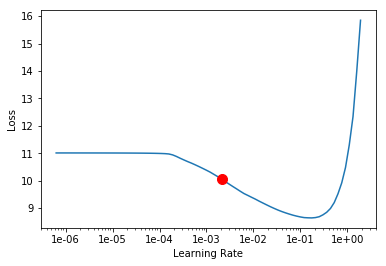

In [10]:
learn.lr_find()
learn.recorder.plot()

In [50]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

| epoch | train_loss | valid_loss | accuracy |
|-------|------------|------------|----------|
| 1     | 5.689881   | 5.479321   | 0.176962 |
| 2     | 5.14165    | 4.914922   | 0.223256 |
| 3     | 4.945699   | 4.661891   | 0.242748 |
| 4     | 4.708307   | 4.471861   | 0.261348 |
| 5     | 4.636846   | 4.337728   | 0.273785 |
| 6     | 4.487616   | 4.237517   | 0.285252 |
| 7     | 4.370384   | 4.161622   | 0.293807 |
| 8     | 4.291326   | 4.100852   | 0.30109  |
| 9     | 4.267814   | 4.071167   | 0.303888 |
| 10    | 4.217663   | 4.065733   | 0.304822 |

In [51]:
# learn.unfreeze()
# learn.fit_one_cycle(10, 1e-3/3, moms=(0.8, 0.7))

| epoch | train_loss | valid_loss | accuracy |
|-------|------------|------------|----------|
| 1     | 4.179729   | 4.052608   | 0.304963 |
| 2     | 4.16306    | 4.047963   | 0.305331 |
| 3     | 4.184966   | 4.044866   | 0.305482 |
| 4     | 4.218517   | 4.023499   | 0.307901 |
| 5     | 4.183966   | 4.001536   | 0.310346 |
| 6     | 4.165901   | 3.985509   | 0.312516 |
| 7     | 4.091527   | 3.966779   | 0.315573 |
| 8     | 4.078772   | 3.952682   | 0.317021 |
| 9     | 4.020618   | 3.944576   | 0.318096 |
| 10    | 4.043382   | 3.94425    | 0.317961 |

In [ ]:
# learn.save('thwiki_lm')
# learn.save_encoder('thwiki_enc')

### Eyeballing Test
We perform eyeballing test by having the model "fill in the blanks".

In [3]:
from utils import *
from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger
data_path = 'th-all-unk/'
model_path = 'thwiki_data/'

#data
data = load_data(model_path,'thwiki_lm_data.pkl')
data.sanity_check()

#lm
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

#load weights
learn.load('thwiki_lm');

In [24]:
learn.predict('สวัสดีครับ พี่น้องเสื้อ',100, sep='', temperature = 0.5)

'สวัสดีครับ พี่น้องเสื้อแดง=รองเท้าแดงเสื้อแดง(อังกฤษ:St.โก้)เป็นภาพยนตร์ไทยแนวตลก-แฟนตาซีออกฉายในปีพ.ศ.2544กำกับโดยยุทธนามุกดาสนิทนำแสดงโดยสันติสุขพรหมศิริ,สุวนันท์คงยิ่ง,สุรชัยจันทิมาธร,บุญชูสกุลเจริญสุข,สุกัญญาวงศ์สวัสดิ์,สุกัญญาไชยศิริ,วิยะดาอุมารินทร์,นิรุตติ์ศิริจรรยา,อุบลรัตน์ปิยะศิริ,สุรชัยจันทิมาธร,รัช'

## Embeddings

We extract the embedding layer of the encoder to be used in the same manner as `word2vec`. We can also create sentence vector by summing or averaging the vectors. For more details about `word2vec` use cases, see`word2vec_examples.ipynb`. Note that we use word vectors from `v0.1` since it was trained specifically for the purpose and has comparable dimensions to `fastText` embeddings.

### Extract

In [8]:
#how we extracted the embeddings
emb_weights = list(learn.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)
emb_np.shape

(60003, 400)

In [33]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(f'{model_path}models/thai2vec.vec',binary=False,
                                         unicode_errors = 'ignore')

In [35]:
model.save_word2vec_format(f'{model_path}models/thai2vec.vec',f'{model_path}models/thai2vec.vocab',False)
model.save_word2vec_format(f'{model_path}models/thai2vec.bin',None,True)

## Document Vectors

We can also get document vector from the language model by applying the encoder to a sentence.

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tt = ThaiTokenizer()
def document_vector(ss, learn, data):
    s = tt.tokenizer(ss)
    t = torch.tensor(data.vocab.numericalize(s), requires_grad=False).to(device)
    m = learn.model[0].encoder.to(device)
    res = m(t).mean(0).cpu().detach().numpy()
    return(res)

In [93]:
ss = 'วันนี้วันดีปีใหม่'
document_vector(ss,learn,data)

array([ 0.066298,  0.307813,  0.246051,  0.008683, ..., -0.058363,  0.133258, -0.289954, -1.770246], dtype=float32)

In [4]:
from pythainlp.ulmfit import *
document_vector('วันนี้วันดีปีใหม่',learn,data)

array([ 0.066298,  0.307813,  0.246051,  0.008683, ..., -0.058363,  0.133258, -0.289954, -1.770246], dtype=float32)